# Learning and Decision Making

## Laboratory 4: Supervised learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The LFW dataset

The LFW (Labeled Faces in the Wild) data set is a collection of JPEG pictures of famous people collected over the internet. Each picture is centered on a single face and corresponds to a grayscale image of 62 $\times$ 47 pixels. 

---

We start by loading the dataset, selecting only those people in the dataset that appear in at least 50 pictures.

In [5]:
%matplotlib notebook
from sklearn import datasets, model_selection, linear_model
from sklearn.decomposition import RandomizedPCA
from time import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>


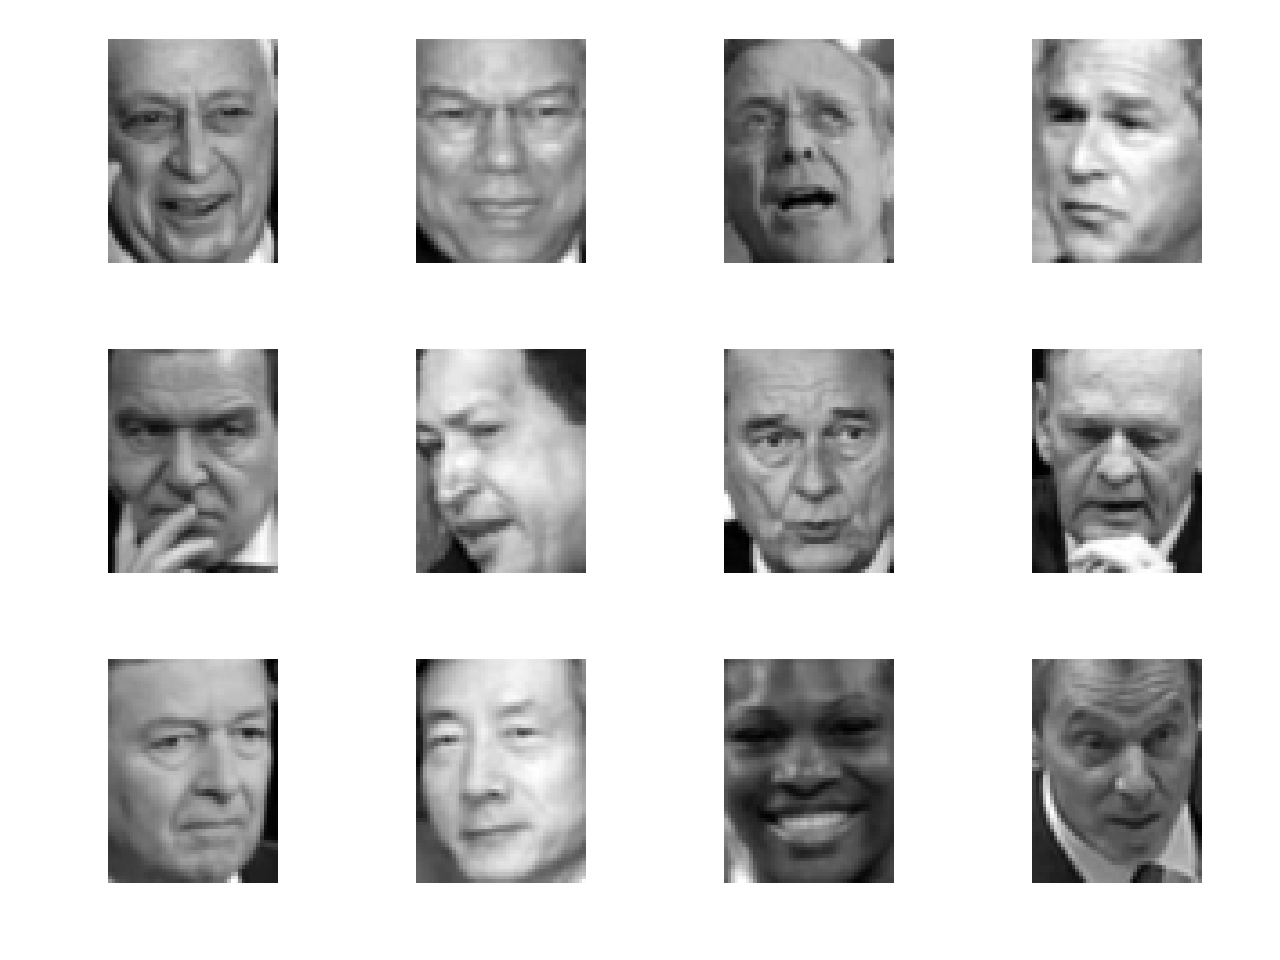

In [8]:
def load_data():
    """
    Load dataset
    :return: dict-like object: lfw; pixel: h, w
    """
    lfw = datasets.fetch_lfw_people(min_faces_per_person=50)
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = lfw.images.shape
    print("n_samples: %d\n" % n_samples)
    print("h: %d\n" % h)
    print("w: %d\n" % w)
    return lfw, h, w

fig = plt.figure()

# Print sample digits
for i in range(12): 
    plt.subplot(3, 4, i + 1)
    idx=list(lfw.target).index(i)
    plt.imshow(lfw.images[idx], cmap=plt.cm.gray)
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running the learning algorithm.

---

#### Activity 1.        

From the LFW dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `lfw`; the corresponding output data can be accessed as the attribute `target` in `lfw`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to 10% of your data. 

**Note:** Don't forget to import `numpy` and the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number.

---

In [7]:
def split_data(lfw, k):
    """
    Split into a training data
    for machine learning we use the 2 data directly
    :param lfw: dataset
    :param k: component
    :return: List containing train-test split of inputs
    """
    x = lfw.data
    n_features = x.shape[1]
    print("n_features: %d\n" % n_features)
    # the label to predict is the id of the person
    y = lfw.target
    target_names = lfw.target_names
    n_classes = target_names.shape[0]
    print("target_names: {}\n".format(target_names))
    print("n_classes: %d\n" % n_classes)
    # split into a training and testing set
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=k)
    return x_train, x_test, y_train, y_test, n_classes, target_names

lfw, h, w = load_data()
xtrain, xtest, ytrain, ytest, n_classes, target_names = split_data(lfw, 0.10)


n_samples: 1560

h: 62

w: 47

n_features: 2914

target_names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

n_classes: 12



Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to 3,000 features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ and can be computed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _normalize_ the data to make sure that all inputs lie in the same range. In our case, since all pixels lie in the same range, normalization is not necessary.

---

In [10]:
def compute_pca(x_train, x_test, h, w, k):
    """
    Compute a PCA (eigenfaces) on the face dataset
    :param x_train: training data
    :param x_test: test data
    :param h: pixel
    :param w: pixel
    :param k: component
    :return: dimensionality reduction sets
    """
    n_components = k

    print("Extracting the top %d eigenfaces from %d faces" % (n_components, x_train.shape[0]))
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(x_train)
    print("done in %0.3fs" % (time() - t0))
    eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    print("done in %0.3fs" % (time() - t0))
    return eigenfaces, x_train_pca, x_test_pca

eigenface, xtrain_pca, xtest_pca = compute_pca(xtrain, xtest, h, w, 50)


Extracting the top 50 eigenfaces from 1404 faces
done in 0.092s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s


Note how 50 components explain almost 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those 50 components as features to represent our data. 

However, to clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{10, 20, ..., 100\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data, with $C=1000$
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 30 times.

** Note: ** The whole process may take a while, so don't despair. The logistic classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [87]:
def compute_lr(xtrain_pca, ytrain, xval_pca, comp):
    """
    Quantitative evaluation of the model quality on the test set
    :param xtrain_pca: pca training set
    :param ytrain: training set
    :param xval_pca: validation training det
    :param comp: component
    :return: prediction set
    """
    t0 = time()
    logistic_train = linear_model.LogisticRegression(C=comp).fit(xtrain_pca, ytrain)
    print("LR done in %0.3fs" % (time() - t0))
    print("Predicting the input data")
    t0 = time()
    ytrain_predicted = logistic_train.predict(xtrain_pca)
    yval_predicted = logistic_train.predict(xval_pca)
    print("done in %0.3fs" % (time() - t0))
    return ytrain_predicted, yval_predicted


def activity_3_aux(h, w, xtrain, xval, ytrain, yval, comp):
    """
    Auxiliar function
    :param h: pixel
    :param w: pixel
    :param xtrain: training set
    :param xval: validation set
    :param ytrain: training set
    :param yval: validation set
    :param comp: component
    :return: accuracy set
    """
    k = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    accuracy_train = []
    accuracy_val = []
    for i in k:
        eigenface, xtrain_pca, xval_pca = compute_pca(xtrain, xval, h, w, i)
        ytrain_predicted, yval_predicted = compute_lr(xtrain_pca, ytrain, xval_pca, comp)
        accuracy_xtrain = accuracy_score(ytrain, ytrain_predicted)
        accuracy_xval = accuracy_score(yval, yval_predicted)
        accuracy_train += [1-accuracy_xtrain]
        accuracy_val += [1-accuracy_xval]
    return accuracy_train, accuracy_val


def activity3(x, y, h, w, p, comp):
    """
    :param x: training set
    :param y: training set
    :param h: pixel
    :param w: pixel
    :param p: % test size
    :param comp: component
    :return: accuracy set
    """
    t0 = time()
    accuracy_train_all = []
    accuracy_val_all = []
    for i in range(30):
        xtrain, xval, ytrain, yval = model_selection.train_test_split(x, y, test_size=p)
        accuracy_xtrain, accuracy_xval = activity_3_aux(h, w, xtrain, xval, ytrain, yval, comp)
        accuracy_train_all += [accuracy_xtrain]
        accuracy_val_all += [accuracy_xval]

    print("Activity 3 done in %0.3fs" % (time() - t0))
    print("accuracy train all: {}\n".format(accuracy_train_all))
    print("accuracy val all: {}\n".format(accuracy_val_all))
    return accuracy_train_all, accuracy_val_all


accuracy_train_all, accuracy_val_all = activity3(xtrain, ytrain, h, w, 0.15, 1000)

Extracting the top 10 eigenfaces from 1193 faces
done in 0.039s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.012s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.029s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.042s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.052s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.042s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.102s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.055s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.144s
Predicting the input data
done in 0.001s


LR done in 0.052s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.042s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.100s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.052s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s
LR done in 0.132s
Predicting the input data
done in 0.001s
Extracting the top 60 eigenfaces from 1193 faces
done in 0.063s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.209s
Predicting the input data
done in 0.001s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.071s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.255s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.081s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s


done in 0.054s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.146s
Predicting the input data
done in 0.001s
Extracting the top 60 eigenfaces from 1193 faces
done in 0.067s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.187s
Predicting the input data
done in 0.001s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.072s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.280s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.085s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
LR done in 0.308s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.086s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.274s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces

done in 0.011s
LR done in 0.155s
Predicting the input data
done in 0.001s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.071s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
LR done in 0.278s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.080s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.320s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.092s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s
LR done in 0.271s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.098s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.311s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.034s
Projecting the input data on the eigenfaces orthonormal basis

LR done in 0.285s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.086s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.374s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.093s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
LR done in 0.301s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.102s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.449s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.013s
Predicting the input data
done in 0.001s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s

LR done in 0.437s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.093s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.304s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.102s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.354s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.039s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.012s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.037s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.028s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.035s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s

LR done in 0.283s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.095s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.563s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.033s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.013s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.037s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.026s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.035s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.051s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.041s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s

LR done in 0.410s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.033s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.013s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.036s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.027s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.039s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.053s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.041s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.084s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.051s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s


---

#### Activity 4.        

Plot the average training and validation error from Activity 3 as a function of $k$. Comment.

---

<IPython.core.display.Javascript object>


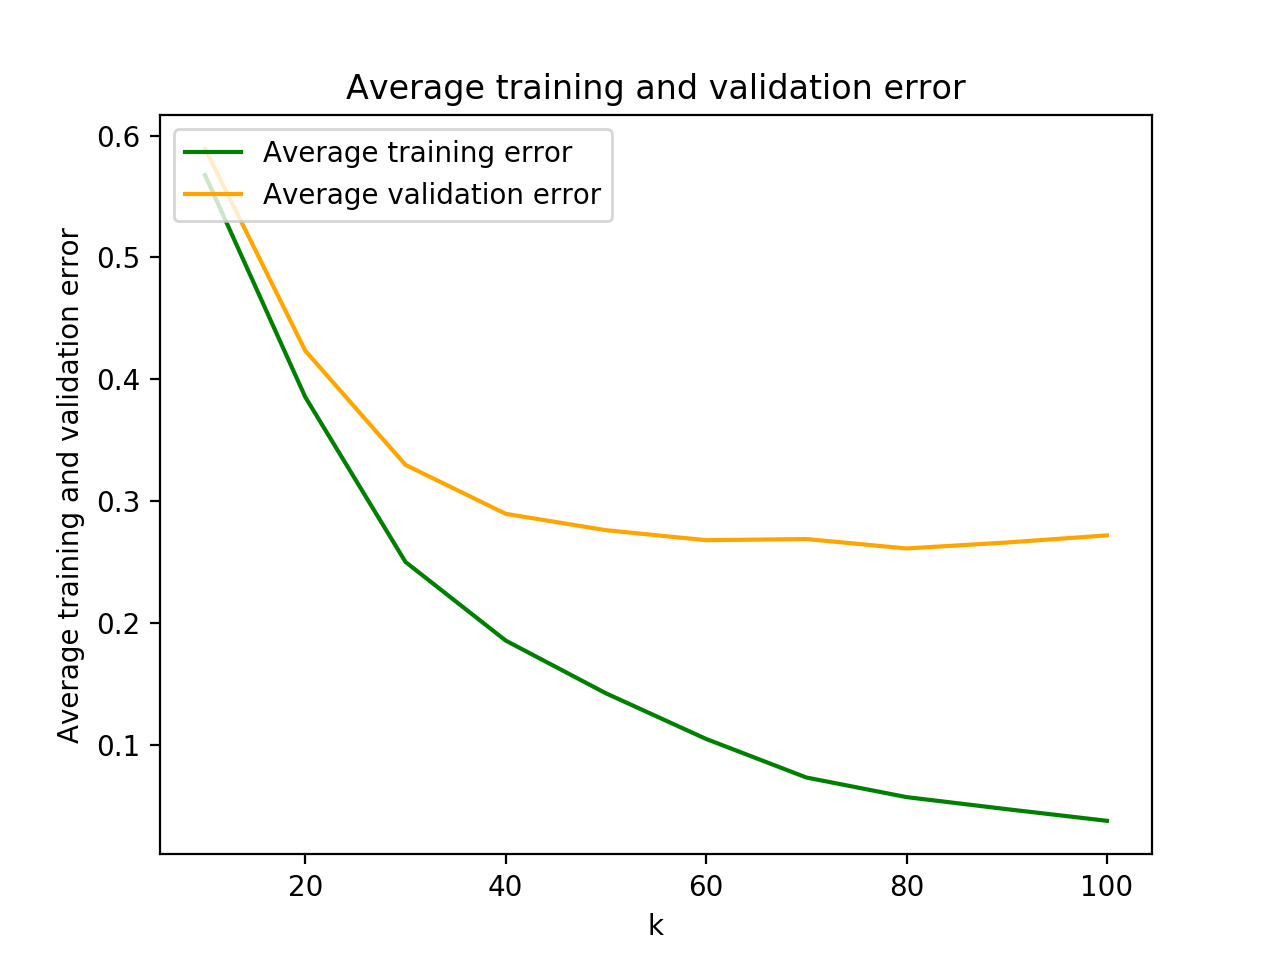

In [88]:
def mean_value(list):
    """
    Mean value of a list
    :param list: list
    :return: mean value
    """
    list_mean = []
    np_list = np.array(list)
    for i in range(len(np_list[0])):
        list_mean += [np_list[:, i].sum() / len(np_list[:, i])]
    return list_mean

def activity_4(accuracy_train_all, accuracy_val_all):
    """
    plot the etc
    :param accuracy_train_all: accuracy of trainig set
    :param accuracy_val_all: accuracy of validation set
    """
    k = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    train_mean = mean_value(accuracy_train_all)
    val_mean = mean_value(accuracy_val_all)
    fig = plt.figure()
    plt.plot(k, train_mean, color='g')
    plt.plot(k, val_mean, color='orange')
    plt.xlabel('k')
    plt.ylabel('Average training and validation error')
    plt.title('Average training and validation error')
    plt.legend(['Average training error', 'Average validation error'], loc='upper left')
    plt.show()

    
activity_4(accuracy_train_all, accuracy_val_all)

As seen in the homework, the logistic regression model is trained to minimize the cost function

$$J(\pi)=-\frac{1}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

However, the logistic regression model in `scikit-learn` uses a slightly different cost function; this modified cost function includes a term that penalizes large values for the parameters $\mathbf{w}$ and takes the general form

$$J(\pi)=\frac{1}{2}\|w\|^2-\frac{C}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

The first term is called a _regularization term_ and the constant $C$ expresses how much we are willing to pay (in terms of errors in the training set) to have small parameter vectors. In activity 3 you used a large value for $C$, indicating the algorithm that errors in the training set should be minimized.

---

#### Activity 5.

Repeat Activity 3 but now setting $C=1$. Plot the results and comment.

---

Extracting the top 10 eigenfaces from 1193 faces
done in 0.057s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.011s
Predicting the input data
done in 0.001s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.022s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.041s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.035s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.042s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.047s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.053s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.058s
Predicting the input data
done in 0.001s


done in 0.051s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.039s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.051s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s
LR done in 0.052s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.057s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.057s
Predicting the input data
done in 0.001s
Extracting the top 60 eigenfaces from 1193 faces
done in 0.060s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.068s
Predicting the input data
done in 0.001s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.066s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.080s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces


done in 0.082s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.019s
LR done in 0.095s
Predicting the input data
done in 0.001s
Extracting the top 60 eigenfaces from 1193 faces
done in 0.082s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
LR done in 0.087s
Predicting the input data
done in 0.002s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.080s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
LR done in 0.102s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.082s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s
LR done in 0.151s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.110s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
LR done in 0.133s
Predicting the input data
done in 0.002s
Extracting the top 100 eigenfaces from 1193 faces

done in 0.074s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.081s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.089s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.102s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.081s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.108s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.104s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.150s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.039s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.012s
Predicting the input data
done in 0.001s
Extracting the top 20 eigenfaces from 1193 faces

LR done in 0.105s
Predicting the input data
done in 0.001s
Extracting the top 90 eigenfaces from 1193 faces
done in 0.093s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.114s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.100s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.131s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.011s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.032s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.024s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.036s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s

LR done in 0.118s
Predicting the input data
done in 0.001s
Extracting the top 100 eigenfaces from 1193 faces
done in 0.100s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
LR done in 0.136s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.034s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.011s
Predicting the input data
done in 0.000s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.033s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.022s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.035s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.033s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.044s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s

LR done in 0.131s
Predicting the input data
done in 0.001s
Extracting the top 10 eigenfaces from 1193 faces
done in 0.034s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.011s
Predicting the input data
done in 0.001s
Extracting the top 20 eigenfaces from 1193 faces
done in 0.033s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.023s
Predicting the input data
done in 0.001s
Extracting the top 30 eigenfaces from 1193 faces
done in 0.036s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
LR done in 0.034s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.043s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.046s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.048s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s


LR done in 0.033s
Predicting the input data
done in 0.001s
Extracting the top 40 eigenfaces from 1193 faces
done in 0.043s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
LR done in 0.046s
Predicting the input data
done in 0.001s
Extracting the top 50 eigenfaces from 1193 faces
done in 0.046s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.056s
Predicting the input data
done in 0.001s
Extracting the top 60 eigenfaces from 1193 faces
done in 0.068s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
LR done in 0.068s
Predicting the input data
done in 0.001s
Extracting the top 70 eigenfaces from 1193 faces
done in 0.066s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
LR done in 0.080s
Predicting the input data
done in 0.001s
Extracting the top 80 eigenfaces from 1193 faces
done in 0.090s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s


<IPython.core.display.Javascript object>


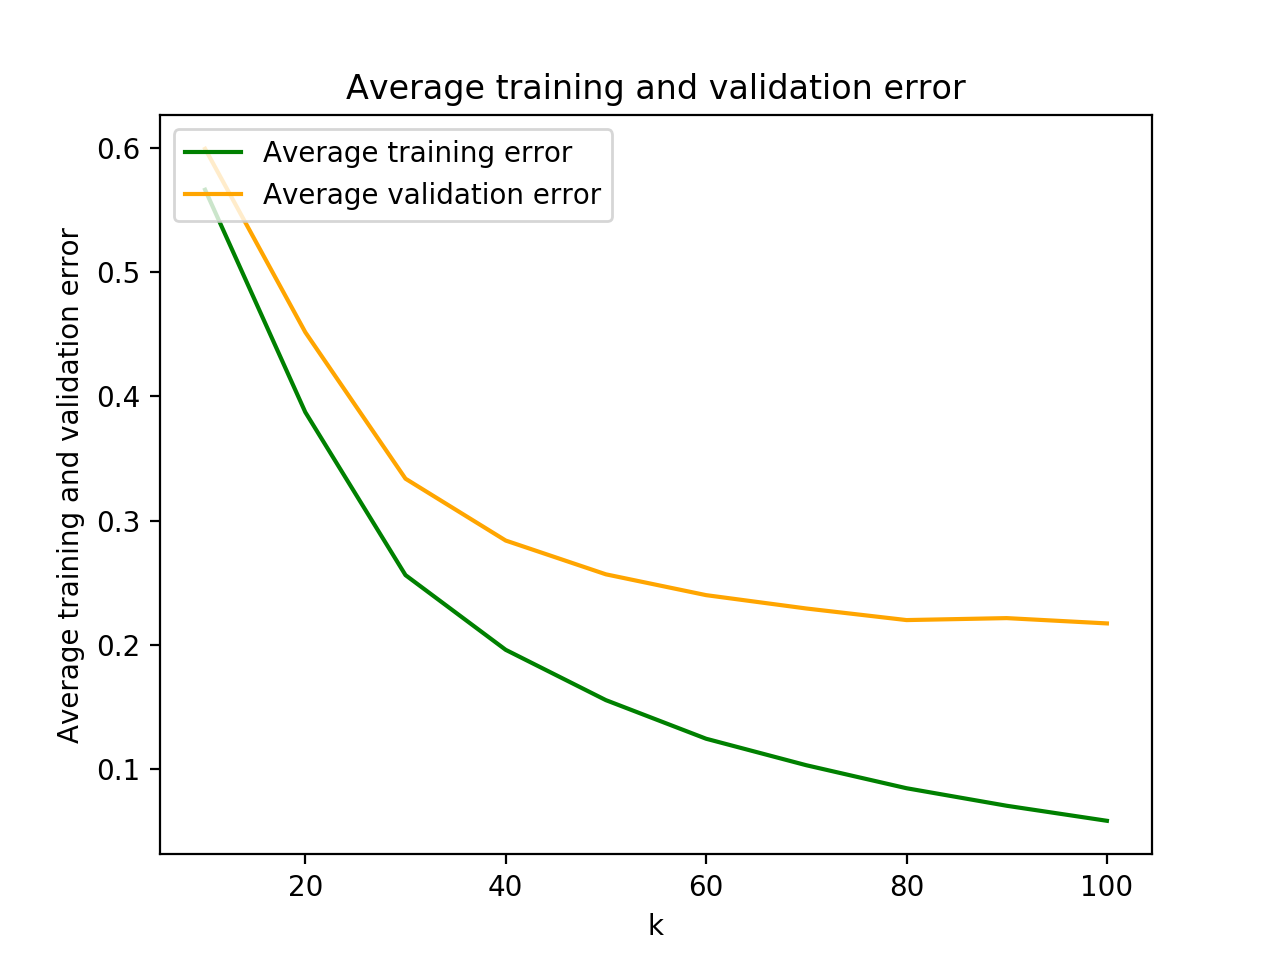

In [89]:
accuracy_train_all2, accuracy_val_all2 = activity3(xtrain, ytrain, h, w, 0.15, 1)
activity_4(accuracy_train_all2, accuracy_val_all2)


In light of the results, we can now safely train our classifier with a larger number of components (say, $k=80$) by setting $C=1$ to avoid overfitting.

---

#### Activity 6.

* Retrain your PCA model with $k=80$ components---now using all your training data;
* Retrain the logistic regression model;
* Compute the performance of the resulting model in the test data (don't forget to transform the test data).

In particular, compute both the accuracy score and print the confusion matrix (which you can access from `sklearn.metrics`). Comment the obtained results in face of Activities 3-5.

---

In [9]:

def activity_6(xtrain, xtest, ytrain, ytest, h, w, k, n_classes, target_names):
    """
    Plot the somethinf
    :param xtrain: training data set
    :param xtest: test data set
    :param ytrain: training data set
    :param ytest: test data set
    :param h: pixel
    :param w: pixel
    :param k: component
    :param n_classes: classes
    :param target_names: names
    """
    eigenfaces, x_train_pca, x_test_pca = compute_pca(xtrain, xtest, h, w, k)
    ytrain_predicted, ytest_predicted = compute_lr(x_train_pca, ytrain, x_test_pca, 1)
    # accuracy_train = accuracy_score(ytrain, ytrain_predicted)
    accuracy_test = accuracy_score(ytest, ytest_predicted)
    # print("accuracy train all: {}\n".format(accuracy_train))
    print("accuracy val all: {}\n".format(accuracy_test))
    cr = classification_report(ytest, ytest_predicted)
    print(cr)
    cm = confusion_matrix(ytest, ytest_predicted, labels=range(n_classes))
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    # plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(target_names, rotation=90, fontsize=8)
    ax.set_yticklabels(target_names, rotation=0, fontsize=8)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(target_names)
    
    
activity_6(xtrain, xtest, ytrain, ytest, h, w, 80, n_classes, target_names)

print("\n\033[4m\033[1mConclusions:\033[1m\033[0m")
print("The confusion matrix evaluates the quality of the output of the classifier on our dataset. The diagonal elements represent the number of points for which the predicted value is equal to the true label, while off-diagonal elements are those that are mislable by our classifier. The higher the diagonal values of the confusion matrix the bette, indicating many correct predictions.")
print("\nThe C value, the inverse of regularization strength in logistic regression, is value that 'apply' a penalty to increase the magnitude of a parameter value in other to reduce overfitting. This minimize the error between what the model predicts. Smaller values specify stronger regularization.")
print("\nThe matrix above shows the confusion matrix for 80 components.")
print("\n\033[4mHere the results are the following:\033[0m")
print("1 - The overall classification accuracyequals nearly 79%. E.g. about 79% of pixels are correctly assigned, and 21% of pixels are assigned with errors.")
print("2 - Also, each specific class accuracy is shown in the matrix above. From the twelve classes, George W Bush have the highest classification accuracy, followed by Colin Powell and Schroeder. Theses three classes accuracy can be considered high, it is hardly so for other classes.")
print("3 - The difference between activity 3 and 4 can be explained by the C value as explained above.")


NameError: name 'compute_pca' is not defined